In [ ]:
# library supporting numerical computations
import numpy as np

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# aesthetics considerations
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family']      = 'STIXGeneral'

# library to load the iris dataset from
from sklearn.datasets import load_iris
from sklearn import datasets

## M124 - Coursework 1, Problem 2

---

This coursework is submitted as part of the requirements for the Machine Learning (M124) course in the DSIT's Master degree programme, of the National and Kapodistrian University of Athens. The authors of this project are (in alphabetical order):

- Kyriakos Psallidas (SID: **7115152200033**)
- Michael  Darmanis  (SID: **7115152200004**)
- Vasilios Venieris  (SID: **7115152200017**).

The coursework is about implementing a k-nearest neighbors (k-NN) classifier and using it to classify two datasets: the IRIS PLANT and the PIMA INDIANS DIABETES. The goal was to report the percentage of correct classification as a function of the number of nearest neighbors, using cross-validation to obtain the results.

Additionally, for the PIMA INDIANS DIABETES DATABASE, estimations od the probability density functions (PDFs) using different assumptions were performed and measures of the goodness of the fits were calculated. Furthermore, a Bayes classifier was implemented, and its performance with the k-NN classifier was compared.

Finally, the perceptron algorithm was used to examine whether the data of each class (of the IRIS PLANT DATABASE) is linearly separable from the data of the combined remaining classes.

Throughout the development of this work, the authors have made a conscious effort to use as low-level programming as possible. Additionally, matrix operations have been utilised whenever possible to ensure optimal performance. The code also includes certain classes and global functions that have been created to facilitate the implementation of the methodologies. Explanations of how these functions and classes work are explicitly mentioned and are provided when they are invoked in the code. Furthermore, the authors have included additional comments on methodology in certain places, where they deemed necessary, to provide a deeper understanding of the solution.

It should also be noted that the code in this notebook was created by a team of three, and as a result, the implementation and style thereof will vary. 

---

# Exercise 2.1

Program and implement a k-nearest neighbours classifier (k-ΝΝ). Use this classifier to solve the following problems:
<ol type = "i">
  <li>IRIS PLANT DATABASE (Classification of three different kinds of iris plants).</li>
  <li>PIMA INDIANS DIABETES DATABASE (Classification of pregnant Indians of the Pima tribe according to whether they suffer from diabetes or not).</li>
</ol>

Τhe relevant data can be found in the file UCIdata-exercise1.rar. Report on the percentage of correct classification as a function of the number of nearest neighbours. Use cross-validation to obtain the results.

## Solution

For implementing the k-nearest neighbours (KNN) algorithm, and for obtaining the classification accuracy using cross-validation, the `KNN` class was created. It contains five methods: `fit`, `predict`, `_predict`, `shuffle_dataset` and `cross_val_score`.

The `fit` method stores the training data (`X` and `y`) as instance variables. The training data consists of a feature-array of samples `X` and a label-array `y`.

The `predict` method takes an array of samples `X` and returns a list of predictions, one for each sample. The predictions are made by calling the `_predict` method on each sample.

The `_predict` method is a helper method that makes a prediction for a single sample `x`.

The `shuffle_dataset` method shuffles the indices of the whole dataset, prior to pefroming cross-validation, for data that has been sorted.

The `cross_val_score` method performs k-fold cross-validation on the training data. It splits the data into k folds, trains the model on k-1 folds, and then tests it on the remaining fold. It repeats this process k times, using a different fold as the test set each time. It returns the mean accuracy of the model across all k folds.

The class overall does the following:
1. Computes the provided metric measure (default is the `euclidean_distance` function, as mathematically showcased here) between the sample `x` and all training points `X_train`:
$$d(x, x_{train}) = \sqrt{\sum_{i=1}^{n}(x_i - x_{train,i})^2},$$ where $n$ is the number of features.

2. Finds the $k$ training points that are closest to the sample `x` (the nearest neighbors). This is done by sorting the distances in ascending order and selecting the indices of the first $k$ elements.

3. Gets the labels of the $k$ nearest neighbors using the indices obtained in step 2.

4. Returns the label that appears most frequently among the $k$ nearest neighbors.

The parameter `k` specifies the number of nearest neighbors to consider and is set to 3 by default. It can be changed by passing a different value to the `KNN` constructor when creating an instance of the class.

In [ ]:
def minkowski_distance(x1, x2, p):
    # compute the Minkowski distance between two points
    # where p is the order of the Minkowski metric
    distance = np.sum(np.abs(x1 - x2)**p)**(1/p)
    return distance

def euclidean_distance(x1, x2):
    # compute the Euclidean distance between two points
    p = 2
    distance = minkowski_distance(x1, x2, p) 
    return distance

def median_distance(x1, x2):
    # compute the Median distance between two points
    distance = np.median(np.abs(x1 - x2))
    return distance

def manhattan_distance(x1, x2):
    # compute the Manhattan distance between two points
    p = 1
    distance = minkowski_distance(x1, x2, p)
    return distance

def mahalanobis_distance(x1, x2, S):
    # compute the Mahalanobis distance between two points
    # where S is the covariance matrix of the training data
    distance = np.sqrt((x1 - x2).T @ S @ (x1 - x2))
    return distance

def chebyshev_distance(x1, x2):
    # compute the Chebyshev distance between two points
    p = float('inf') 
    distance = minkowski_distance(x1, x2, p) 
    return distance 

class KNN:
    """
    The KNN class represents an implementation of the K-Nearest Neighbors model.

    Attributes:
    -----------
    k: an int representing the number of nearest neighbors to consider when
       making a prediction (default is 3)
    X_train: a numpy array of shape (n_samples, n_features) representing the
             training data
    y_train: a numpy array of shape (n_samples,) representing the labels of the
             training data
    metric: a function that takes in two points and returns a distance measure
            between them
    S: a numpy array representing the inverse of the covariance matrix,
       used when the Mahalanobis distance is the metric

    Methods:
    --------
    fit: fits the model to the training data
    predict: makes predictions for a set of test samples
    _predict: makes a prediction for a single test sample
    shuffle_dataset: shuffles entire dataset just in case that it is sorted
                     in some way
    cross_val_score: performs cross-validation on the model
    """
    def __init__(self, k = 3, S = None, metric = euclidean_distance):
        self.k      = k
        self.S      = S
        self.metric = metric

    def fit(self, X, y):
        # store the training data
        self.X_train = X
        self.y_train = y

        # compute the inverse of the covariance matrix of the training data 
        # when using the Mahalanobis distance
        if self.metric == mahalanobis_distance:
           self.S = np.linalg.inv(np.cov(X.T))

    def predict(self, X):
        # make a prediction for each sample in X
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        # compute the distance between the test point and all training points
        if self.metric == mahalanobis_distance:
           distances = [self.metric(x, x_train, self.S) for x_train in self.X_train]
        else:
           distances = [self.metric(x, x_train) for x_train in self.X_train]

        # get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]

        # get the labels of the k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # return the label that appears most frequently
        most_common = np.bincount(k_nearest_labels)
        return np.argmax(most_common)

    def shuffle_dataset(self, X, y):
      # add seed for consisten shuffling
        # create a combined array of the features and labels
        data = np.column_stack((X, y))

        # shuffle the rows of the data
        np.random.seed(50)
        np.random.shuffle(data)

        # split the data back into features and labels
        X_shuffled = data[:, :-1]
        y_shuffled = data[:, -1]
        return X_shuffled, y_shuffled

    def cross_val_score(self, X, y, cv = 5):
        # shuffle the data
        X, y = self.shuffle_dataset(X, y)

        # split the data into cv folds
        fold_size = X.shape[0] // cv

        scores = []
        for i in range(cv):
            # get the indices of the training and test sets
            test_indices  = range(i * fold_size, (i + 1) * fold_size)
            train_indices = list(set(range(X.shape[0])) - set(test_indices))

            # split the data into training and test sets
            X_train, y_train = X[train_indices], y[train_indices]
            X_test, y_test   = X[test_indices], y[test_indices]

            # fit the model on the training data
            self.fit(X_train, y_train)

            # make predictions on the test data
            predictions = self.predict(X_test)

            # compute the accuracy of the model
            score = (predictions == y_test).mean()
            scores.append(score)
        return np.mean(scores)

---

The `KNN` class is implemented on the IRIS dataset drawn from `sklearn.datasets`. It is run for 30 consecutive times, for k number of nearest neigbhours, and the percentage of correct classification is displayed in a plot as a function of the number of nearest neighbours.

The iris data consists of four features: sepal length, sepal width, petal length, and petal width, all measured in centimeters. Since all the features are in the same unit, they are already on a similar scale and there is no need for normalisation.

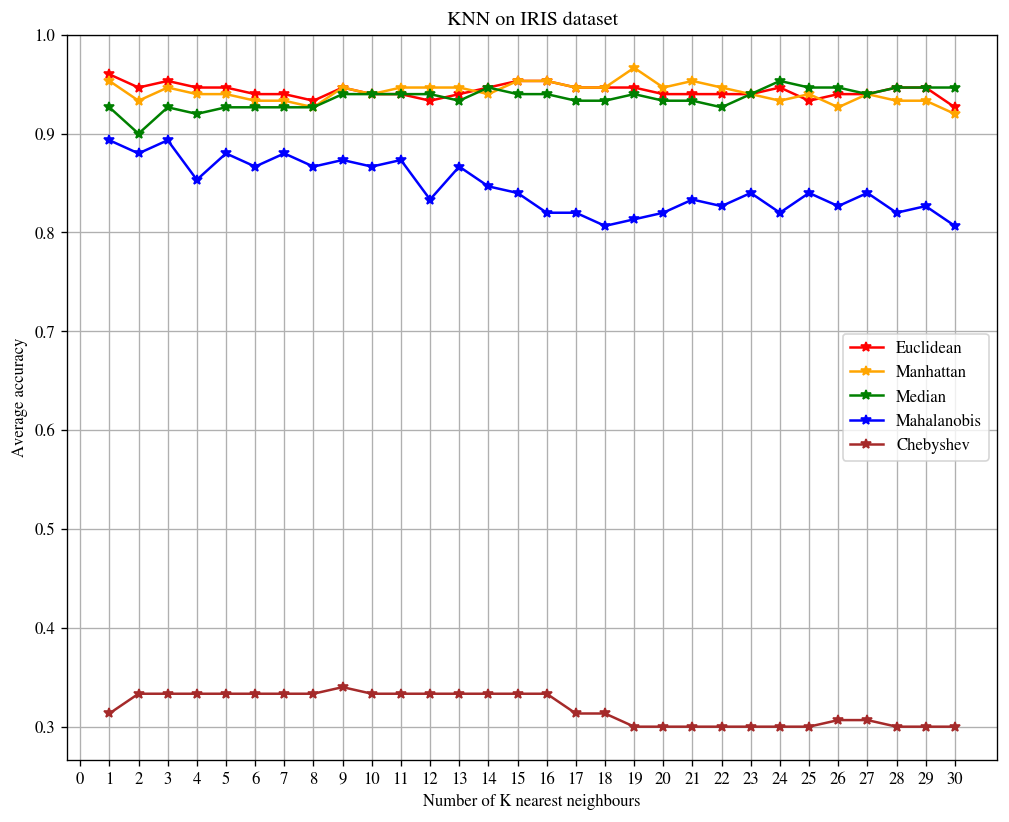

| Metric             | Maximum Accuracy | K-Value |
|--------------------|------------------|---------|
| Euclidean          | 0.96             | 1       |
| Manhattan          | 0.97             | 19      |
| Median             | 0.95             | 24      |
| Mahalanobis        | 0.89             | 1       |
| Chebyshev          | 0.34             | 9       |


In [ ]:
# load the iris data
iris = load_iris()
X, y = iris.data, iris.target

# create a list of tuples, each containing the distance metric and its name
metrics = [(euclidean_distance, 'Euclidean'), 
           (manhattan_distance, 'Manhattan'), 
           (median_distance, 'Median'), 
           (mahalanobis_distance, 'Mahalanobis'),
           (chebyshev_distance, 'Chebyshev')]


# apply KNN algorithm for each distance metric and for 30 hyperparameters k 
# keep cross-validation score for each metric
accuracies = []
best_accuracies = []
for metric, name in metrics:
    model      = KNN(metric=metric)
    scores     = []
    for k in range(1, 31):
        model.k = k
        score   = model.cross_val_score(X, y)
        scores.append(score)

    accuracies.append(scores)
    best_index = np.argmax(scores)
    best_accuracy = scores[best_index]
    best_k = best_index + 1
    best_accuracies.append((best_accuracy, best_k))

# plot the cross-validation scores for each metric
plt.figure(figsize = (10, 8), dpi = 120)
colors = ['red', 'orange', 'green', 'blue', 'brown']
for i, (scores, name) in enumerate(zip(accuracies, [name for _, name in metrics])):
    plt.plot(range(1, 31), scores, marker = '*', label = name, color=colors[i])

plt.title('KNN on IRIS dataset')
plt.xlabel('Number of K nearest neighbours')
plt.ylabel('Average accuracy')
plt.xticks(np.arange(0, 31, 1))
plt.grid(True)
plt.legend()
plt.show()

# print best accuracies for each metric
metric_names = ['Euclidean', 'Manhattan', 'Median', 'Mahalanobis', 'Chebyshev']
print("| Metric             | Maximum Accuracy | K-Value |")
print("|--------------------|------------------|---------|")

for metric, (accuracy, k) in zip(metric_names, best_accuracies):
    print(f"| {metric:<18} | {accuracy:.2f}             | {k:<7} |")

**Comments**

It can readily be observed that when implementing the K-Nearest Neighbors (KNN) model on the Iris dataset, both the Chebyshev and Mahalanobis distance metrics do not perform as well as the other distance metrics. This is likely due to the characteristics of the Iris dataset and the nature of the distance metrics themselves.

The Chebyshev distance, also known as infinity norm, is known to be less sensitive to the correlation structure of the data and more sensitive to outliers, which may not be suitable for capturing the underlying patterns in the Iris dataset that are important for classification. 

The Mahalanobis distance, on the other hand, is sensitive to the covariance structure of the data and can perform well when the data is multivariate normal or when the features are highly correlated. However, the Iris dataset is relatively small and simple, with only 150 instances and four features, which may not have enough information to accurately model the covariance structure of the data, leading to suboptimal results.

---

The KNN class is implemented on the PIMA-INDIANS-DIABETES dataset provided by the exercise. It is run for 30 consecutive iterations, each time using a different number of nearest neighbors (k), and the percentage of correct classification is displayed in a plot as a function of the number of nearest neighbors.

The dataset consists of several medical predictor variables and one target variable (outcome). Specifically, the medical predictor variables are:

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

while the outcome is

9. Class variable (0 or 1)

It should be noted that for the features 2 through 8 of the dataset, zero values do not represent valid measurements and are likely missing values that were encoded as zeros. In order to obtain more accurate results, it is necessary to remove the rows corresponding to these zero values. By doing so, it is ensured that the model will not be biased by the presence of invalid zero values, and will be able to make more accurate predictions based on the true distribution of the data.

Moreover, since the medical predictor variables correspond to different physical measurements, it is expected that there will be quantities of different magnitudes present in the data. To ensure that all features are on a comparable scale and have a comparable effect on the distance measure used by the algorithm, it is necessary to apply a normalization scheme.

The chosen normalization scheme is standardization, which is performed on each feature (i.e. column of the feature matrix `X`) by subtracting the mean of the feature from each value and dividing the result by the standard deviation of the feature. This transformation can be mathematically expressed as:

$$z = \frac{x - \mu}{\sigma}$$

where $z$ is the standardized value, $x$ is the original value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.

Standardization ensures that all features have a mean of 0 and a standard deviation of 1. This is important for algorithms that use distance measures, like the parent example, as it ensures that all features are on a similar scale and have a comparable effect on the distance measure.

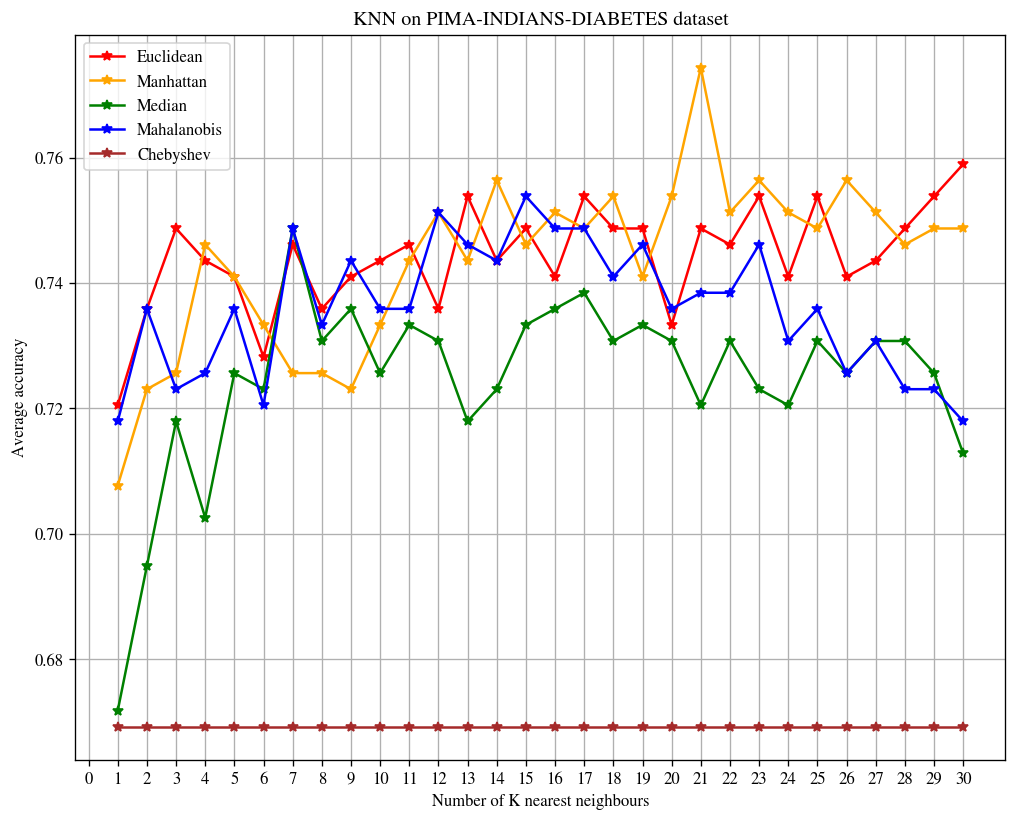

| Metric             | Maximum Accuracy | K-Value |
|--------------------|------------------|---------|
| Euclidean          | 0.76             | 30      |
| Manhattan          | 0.77             | 21      |
| Median             | 0.75             | 7       |
| Mahalanobis        | 0.75             | 15      |
| Chebyshev          | 0.67             | 1       |


In [ ]:
# read the data from the pima-indians-diabetes.data file
data = np.loadtxt('pima-indians-diabetes.data', delimiter = ',')

# split the data into feature matrix X and label vector y
X = data[:, :-1]
y = data[:, -1]

# select the columns for which zero values make no physical sense 
columns  = [1, 2, 3, 4, 5, 6, 7]
X_subset = X[:, columns]

# create indices for rows that do not contain any zeros in the columns of interest
indices = ~np.any(X_subset == 0, axis=1)

# use indices to select the rows that do not contain any zeros in the columns of interest
X = X[indices]
y = y[indices]

# compute the mean and standard deviation of each feature 
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

# standardise features 
X = (X - mean) / std

# create a list of tuples, each containing the distance metric and its name
metrics = [(euclidean_distance, 'Euclidean'), 
           (manhattan_distance, 'Manhattan'), 
           (median_distance, 'Median'), 
           (mahalanobis_distance, 'Mahalanobis'),
           (chebyshev_distance, 'Chebyshev')]

# apply KNN algorithm for each distance metric and for 30 hyperparameters k 
# keep cross-validation score for each metric
accuracies = []
best_accuracies = [] # we need this for comparison with Exercise 2.3
for metric, name in metrics:
    model      = KNN(metric=metric)
    scores     = []
    for k in range(1, 31):
        model.k = k
        score  = model.cross_val_score(X, y)
        scores.append(score)

    accuracies.append(scores)
    best_index = np.argmax(scores)
    best_accuracy = scores[best_index]
    best_k = best_index + 1
    best_accuracies.append((best_accuracy, best_k))

# plot the cross-validation scores for each metric
plt.figure(figsize = (10, 8), dpi = 120)
colors = ['red', 'orange', 'green', 'blue', 'brown']
for i, (scores, name) in enumerate(zip(accuracies, [name for _, name in metrics])):
    plt.plot(range(1, 31), scores, marker = '*', label = name, color=colors[i])

plt.title('KNN on PIMA-INDIANS-DIABETES dataset')
plt.xlabel('Number of K nearest neighbours')
plt.ylabel('Average accuracy')
plt.xticks(np.arange(0, 31, 1))
plt.grid(True)
plt.legend()
plt.show()

# print best accuracies for each metric
metric_names = ['Euclidean', 'Manhattan', 'Median', 'Mahalanobis', 'Chebyshev']
print("| Metric             | Maximum Accuracy | K-Value |")
print("|--------------------|------------------|---------|")

for metric, (accuracy, k) in zip(metric_names, best_accuracies):
    print(f"| {metric:<18} | {accuracy:.2f}             | {k:<7} |")

**Comments**

Again, when implementing the K-Nearest Neighbors (KNN) model on the PIMA-INDIANS-DIABETES dataset, the Chebyshev distance metric performs very poorly compared to other distance metrics. This is likely due to the characteristics of the PIMA-INDIANS-DIABETES dataset and the nature of the Chebyshev distance metric. 

As already stated, the Chebyshev distance is known to be less sensitive to the correlation structure of the data and more sensitive to outliers, which may not be suitable for capturing the underlying patterns in the PIMA-INDIANS-DIABETES dataset that are important for classification. The PIMA-INDIANS-DIABETES dataset is a complex dataset with a high number of features and a large number of instances. The Chebyshev distance may not be able to capture the underlying patterns in the data that are important for classification. The results obtained from the low and stable accuracy testify to that.

It is worth noting that the model's performance was not as effective for the current dataset as for the IRIS dataset. As the dimensionality of the data increases, the similarity between points drawn from a probability distribution diminishes, thereby leading to the breakdown of the k-Nearest Neighbors (kNN) assumption **[1]**. The IRIS dataset comprises four features, while the PIMA-INDIANS-DIABETES dataset comprises eight features.

**[1]** Cover, Thomas, and, Hart, Peter. Nearest neighbor pattern classification[J]. Information Theory, IEEE Transactions on, 1967, 13(1): 21-27 


---
---

# Exercise 2.2

For the second problem (i.e. PIMA INDIANS DIABETES DATABASE) obtain estimates of the probability density functions for each class, under the following assumptions:

<ol type="a">
  <li>PDFs are gaussian. The covariance matrices are diagonal, with all diagonal elements equal. Mean and variance of the pdfs are estimated using Maximum Likelihood from the available data.</li>
  <li>PDFs are gaussian, with non-diagonal covariance matrices. Means and covariance matrices of the pdfs are estimated using Maximum Likelihood from the available data.</li>
  <li>Components of the feature vectors are mutually statistically independent (the usual naïve Bayes approach). Marginal Pdfs are gaussian, with parameters (mean, variance) estimated using Maximum Likelihood from the available data.</li>
  <li>Components of the feature vectors are mutually statistically independent (the usual naïve Bayes approach). Marginal pdfs are computed using 1-d Parzen windows with gaussian kernels. Take the width h of each window equal to the square root of the number of patterns in the available data.
</li>
</ol>

For all assumptions compute the following measures of the goodness of your fit for each class: Akaike Information Criterion (*AIC*), Bayesian Information Criterion (*BIC*) (https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118856406.app5). For this question, use the whole data set available to compute the above measures (do not use cross validation).


## Solution

Following the spirit of Exercise 2.1, a `pdf_estimator` class was created in order to perform the required tasks. This class is a density estimator that models the probability density function (PDF) of a given dataset using the Gaussian distribution. 

The `fit` method estimates the mean and covariance matrix of the Gaussian distribution based on the input data `X`. The pdf method then uses these estimated parameters to compute the PDF at a given set of samples.

There are four different assumptions that can be specified when using the `pdf_estimator` class, which determine the formula used to compute the PDF:

- **Assumption a**: The PDFs are Gaussian and the covariance matrices are diagonal, with all diagonal elements equal. The mean and variance of the PDFs are estimated using Maximum Likelihood from the input data `X`. This is given by $$ f(x|\mu,\Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} \exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right),$$
where $x$ is a d-dimensional random variable, $\mu$ is the mean vector, $\Sigma$ is the diagonal covariance matrix and $n$ is the number of features in the data.

- **Assumption b**: The PDFs are Gaussian, with non-diagonal covariance matrices. The means and covariance matrices of the PDFs are estimated using Maximum Likelihood from the input data `X`. This is given by $$ f(x|\mu,\Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} \exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right),$$ 

- **Assumption c**: The components of the feature vectors are mutually statistically independent (the usual naïve Bayes approach). The marginal PDFs are Gaussian, with parameters (mean, variance) estimated using Maximum Likelihood from the input data `X`. This is given by $$ f(x|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right),$$ 
where $x$ is a random variable, $\mu$ is the mean and $\sigma^2$ is the variance. In this implementation, this formula is used to calculate the PDF for each feature for each sample in the input data and then they are multiplied together to get the final PDF value for each sample, the multiplication formula is $$\prod_{i=1}^{d} f(x_i|\mu_i,\sigma_i^2), $$ where $x_i$ is the i-th feature of the sample, $\mu_i$ is the mean of the i-th feature and $\sigma_i^2$ is the variance of the i-th feature.

- **Assumption d**: The components of the feature vectors are mutually statistically independent (the usual naïve Bayes approach). The marginal PDFs are computed using 1-dimensional Parzen windows with Gaussian kernels. The width of each window is set to the square root of the number of patterns in the input data `X`. This is given by $$ f(x) = \frac{1}{nh^d} \sum_{i=1}^{n} K\left(\frac{x-x_i}{h}\right), $$ where x is a d-dimensional random variable, $x_i$ are the samples in the dataset, $n$ is the number of samples, $h$ is the bandwidth and $K$ is the kernel function: $$ K(u) = \frac{1}{(2\pi)^{\frac{d}{2}}} \exp\left(-\frac{1}{2}x^Tx\right). $$

The `__init__` method initializes the object and sets the `mean`, `var`, and `X` attributes to `None`. It also sets the assumptions attribute to the value passed as an argument to the constructor. The `assumptions` attribute determines which of the four formulas should be used to compute the PDF.

The `aic` method computes the Akaike information criterion (AIC) for the model, which is a measure of the relative quality of statistical models for a given set of data. It is defined as $$2 * k - 2 * ln(L).$$

The `bic` method also computes a criterion for evaluating the relative quality of statistical models, called the Bayesian information criterion (BIC). The BIC is defined as $$ln(n) * k - 2 * ln(L).$$

In both `aic` and `bic` methods, *n* is the number of data points, *k* is the number of parameters in the model, and *L* is the maximum value of the likelihood function of the model.



---



**Note:**
It should be mentioned that the multivariate gaussian formula of **assumption a** is the same as the collection of n independent gausians with mean $\mu_i$ and variance $\sigma_i^2$ respectively, namely the formula of **assumption c**.

In [ ]:
class pdf_estimator:
  def __init__(self, assumptions = 'a'):
    self.mean = None
    self.var  = None
    self.X    = None
    self.assumptions = assumptions
  
  def fit(self, X):
    self.mean = np.mean(X, axis=0)
    if self.assumptions == 'a':
      self.var = np.var(X, axis=0)
    elif self.assumptions == 'b':
      self.mean = np.mean(X, axis=0)
      self.cov = np.cov(X, rowvar=False)
    elif self.assumptions == 'c':
      self.var = np.var(X, axis=0)
    elif self.assumptions == 'd':
      self.X = X

  def pdf(self, X):
    if self.assumptions == "a":
      # Number of features in the data
      n_features = X.shape[1]

      # Assuming all variances are equal
      var = np.mean(self.var)  

      # Covariance matrix with diagonal elements equal to var
      cov = np.eye(n_features) * var  

      # Determinant of the covariance matrix
      det_cov = np.linalg.det(cov)

      # Inverse of the covariance matrix
      inv_cov = np.linalg.inv(cov)

      # Difference between samples and mean
      diff = X - self.mean

      # Exponent in the PDF formula
      exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)

      # PDF value for each sample
      pdf = (1 / (np.sqrt(2 * np.pi) * det_cov)) * np.exp(exponent)
      return pdf

    elif self.assumptions == "b":
      # Number of features in the data
      n_features = X.shape[1]

      # Covariance matrix
      cov = self.cov

      # Determinant of the covariance matrix
      det_cov = np.linalg.det(cov)

      # Inverse of the covariance matrix
      inv_cov = np.linalg.inv(cov)

      # Difference between samples and mean
      diff = X - self.mean

      # Exponent in the PDF formula
      exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)

      # PDF value for each sample
      pdf = (1 / (np.sqrt(2 * np.pi) ** n_features * det_cov)) * np.exp(exponent)
      return pdf
      
    elif self.assumptions == "c":
      #PDF value for each sample
      pdf = 1 / np.sqrt(2 * np.pi * self.var) * np.exp(- (X - self.mean)**2 / (2 * self.var))
      pdf = np.prod(pdf, axis=1)
      return pdf 

    elif self.assumptions == 'd':
      n_samples, n_features = X.shape
      h = np.sqrt(n_samples)  # width of the window
      
      # to make X have shape (n_samples, 1, n_features)
      X_mat = np.expand_dims(X, axis=1)  
      
      # to replicate X (n_samples, n_samples, n_features)
      X_mat = np.repeat(X_mat, n_samples, axis=1)  
      
      # (n_samples, n_samples, n_features)
      diff = X_mat - self.X  
      
      # (n_samples, n_samples, n_features)
      norm = -(diff**2)/(2* h**2) 
      
      # (n_samples, n_samples)
      exponent = np.sum(norm, axis=2) 
      
      #  pdf calculation
      pdf = (1 / h * np.sum(np.exp(exponent), axis=1)) / n_samples
      return pdf

    else:
      raise ValueError("Invalid assumption")

  def aic(self, X):
    n = X.shape[0]
    if self.assumptions == 'a':
      k = X.shape[1] + 1  # add 1 for the variance parameter
    elif self.assumptions == 'b':
      k = X.shape[1] * (X.shape[1] + 1) / 2  # add 1 for the variance parameter
    elif self.assumptions == 'c' or self.assumptions == 'd':
      k = X.shape[1]
    L = np.sum(np.log(self.pdf(X)))
    return 2 * k - 2 * L
  
  def bic(self, X):
    n = X.shape[0]
    if self.assumptions == 'a':
      k = X.shape[1] + 1  # add 1 for the variance parameter
    elif self.assumptions == 'b':
      k = X.shape[1] * (X.shape[1] + 1) / 2  # add 1 for the variance parameter
    elif self.assumptions == 'c' or self.assumptions == 'd':
      k = X.shape[1]
    L = np.sum(np.log(self.pdf(X)))
    return np.log(n) * k - 2 * L

In [ ]:
# read the data from the pima-indians-diabetes.data file
data = np.loadtxt('pima-indians-diabetes.data', delimiter = ',')

# split the data into feature matrix X and label vector y
X = data[:, :-1]
y = data[:, -1]

# select the columns for which zero values make no physical sense 
columns  = [1, 2, 3, 4, 5, 6, 7]
X_subset = X[:, columns]

# create indices for rows that do not contain any zeros in the columns of interest
indices = ~np.any(X_subset == 0, axis=1)

# use indices to select the rows that do not contain any zeros in the columns of interest
X = X[indices]
y = y[indices]

# compute the mean and standard deviation of each feature 
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

# standardise features 
X = (X - mean) / std

# split the data into two classes
X_class_0 = X[y == 0]
X_class_1 = X[y == 1]

# create a pdf_estimator with diagonal covariance matrices
model_class_0_diag = pdf_estimator(assumptions='a')
model_class_1_diag = pdf_estimator(assumptions='a')

# create a pdf_estimator with non-diagonal covariance matrices
model_class_0_nondiag = pdf_estimator(assumptions='b')
model_class_1_nondiag = pdf_estimator(assumptions='b')

# create a pdf_estimator with independent features
model_class_0_indep = pdf_estimator(assumptions='c')
model_class_1_indep = pdf_estimator(assumptions='c')

# create a pdf_estimator with statistically independent features using 1-d Parzen windows
model_class_0_indep_parzen = pdf_estimator(assumptions='d')
model_class_1_indep_parzen = pdf_estimator(assumptions='d')

# fit the models to the data
model_class_0_diag.fit(X_class_0)
model_class_1_diag.fit(X_class_1)
model_class_0_nondiag.fit(X_class_0)
model_class_1_nondiag.fit(X_class_1)
model_class_0_indep.fit(X_class_0)
model_class_1_indep.fit(X_class_1)
model_class_0_indep_parzen.fit(X_class_0)
model_class_1_indep_parzen.fit(X_class_1)

# compute the AIC and BIC measures for each class under all assumptions
aic_class_0_diag         = model_class_0_diag.aic(X_class_0)
bic_class_0_diag         = model_class_0_diag.bic(X_class_0)
aic_class_1_diag         = model_class_1_diag.aic(X_class_1)
bic_class_1_diag         = model_class_1_diag.bic(X_class_1)
aic_class_0_nondiag      = model_class_0_nondiag.aic(X_class_0)
bic_class_0_nondiag      = model_class_0_nondiag.bic(X_class_0)
aic_class_1_nondiag      = model_class_1_nondiag.aic(X_class_1)
bic_class_1_nondiag      = model_class_1_nondiag.bic(X_class_1)
aic_class_0_indep        = model_class_0_indep.aic(X_class_0)
bic_class_0_indep        = model_class_0_indep.bic(X_class_0)
aic_class_1_indep        = model_class_1_indep.aic(X_class_1)
bic_class_1_indep        = model_class_1_indep.bic(X_class_1)
aic_class_0_indep_parzen = model_class_0_indep_parzen.aic(X_class_0)
bic_class_0_indep_parzen = model_class_0_indep_parzen.bic(X_class_0)
aic_class_1_indep_parzen = model_class_1_indep_parzen.aic(X_class_1)
bic_class_1_indep_parzen = model_class_1_indep_parzen.bic(X_class_1)

# print the results in a table-like appearance
print('-' * 37)
print('{:^38}'.format('AIC and BIC measures'))
print('-' * 37)
print('{:<20} {:>2} {:>8}'.format('', 'AIC', 'BIC'))
print('-' * 37)
print('{:>7}'.format('Assumption a'))
print('{:<20} {:>5.2f} {:} {:>5.2f}'.format('class 0', aic_class_0_diag, '', bic_class_0_diag))
print('{:<20} {:>5.2f} {:} {:>5.2f}'.format('class 1', aic_class_1_diag, '', bic_class_1_diag))
print('')
print('{:>7}'.format('Assumption b'))
print('{:<20} {:>5.2f} {:} {:>5.2f}'.format('class 0', aic_class_0_nondiag, '', bic_class_0_nondiag))
print('{:<20} {:>5.2f} {:} {:>5.2f}'.format('class 1', aic_class_1_nondiag, '', bic_class_1_nondiag))
print('')
print('{:>7}'.format('Assumption c'))
print('{:<20} {:>5.2f} {:} {:>5.2f}'.format('class 0', aic_class_0_indep, '', bic_class_0_indep))
print('{:<20} {:>5.2f} {:} {:>5.2f}'.format('class 1', aic_class_1_indep, '', bic_class_1_indep))
print('')
print('{:>7}'.format('Assumption d'))
print('{:<20} {:>5.2f} {:<0} {:>5.2f}'.format('class 0', aic_class_0_indep_parzen,'', bic_class_0_indep_parzen))
print('{:<21} {:>5.2f} {:<0} {:>5.2f}'.format('class 1', aic_class_1_indep_parzen, ' ', bic_class_1_indep_parzen))
print('-' * 37)

-------------------------------------
         AIC and BIC measures         
-------------------------------------
                     AIC      BIC
-------------------------------------
Assumption a
class 0              1654.52  1686.64
class 1              1526.77  1552.57

Assumption b
class 0              3899.95  4028.41
class 1              2839.94  2943.18

Assumption c
class 0              5470.40  5498.95
class 1              3063.35  3086.29

Assumption d
class 0              1487.62  1516.17
class 1               666.44   689.38
-------------------------------------


**Comments**

The resulting AIC and BIC values for the different assumptions of the PDF estimator provide insight into the relative quality of the models under consideration. It can be observed that, generally speaking, the models that assume a multivariate normal distribution with equal variances (assumption 'a') and a kernel density estimation (assumption 'd') tend to perform better, as they have lower AIC and BIC values compared to the other assumptions. In particular, Assumption 'd', by having the lowest AIC and BIC values, is a better fit for the data.


---
---

# Exercise 2.3

For each of the above assumptions about the pdfs, implement a Bayes classifier and compute its classification accuracy using cross validation (it goes without saying that for each cross validation iteration, probability density functions will have to be calculated using only training set data for this question). For assumptions `c` and `d`, this will obviously be a naïve Bayes classifier. Taking into account your previous findings, investigate whether more accurate estimates for the pdfs (as judged by the model selection criteria in [Exercise 2.2](https://colab.research.google.com/drive/1VExOywkzGc5PjIRUdBlKzOiou4nkcWzT#scrollTo=EDlBIKqFD_Yc&line=1&uniqifier=1)) tend to improve classification accuracy as well. Compare the performance of the Bayes classifiers to the performance of the k-NN classifier.

## Solution

Again, following the spirit of the previous exercices, the `bayes_classifier` class was created for handling the required tasks. The class provides an implementation of a Bayesian classifier that can be trained on a given dataset and used to predict the class of new data points, using four different assumptions for estimating the probability density function of the data. The assumptions can be specified when instantiating the class, and the class provides methods for fitting the model to data, making predictions, and shuffling the input dataset. 

The `fit` method estimates the mean, variance, and covariance of the Gaussian distribution based on the input data `X` and `y`. The `predict` method uses these estimated parameters to predict the class of new data points by calculating the posterior probability for each class using the `_pdf` method.

There are four different assumptions that can be specified when using the `bayes_classifier` class (and are computed within the `_pdf` method) which determine the formula used to compute the PDF:

- **Assumption 'a':** The PDFs are Gaussian and the covariance matrices are diagonal, with all diagonal elements equal. The mean and variance of the PDFs are estimated using the input data `X`. This is expressed mathematically as $$p(x|y) = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}} e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)},$$ where $d$ stands for the number of features (dimensions) in the input data `X` and $\Sigma$ is a diagonal matrix whose elements have the same value (the average of the variances for each feature).

- **Assumption 'b':** The PDFs are Gaussian, with non-diagonal covariance matrices. The means and covariance matrices of the PDFs are estimated using the input data `X`. This is expressed mathematically as $$p(x|y) = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}} e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}.$$

- **Assumption 'c':** The components of the feature vectors are mutually statistically independent (the usual naïve Bayes approach). The marginal PDFs are Gaussian, with parameters (mean, variance) estimated using the input data `X`. This is expressed mathematically as $$p(x|y) = \prod_{j=1}^D \frac{1}{\sqrt{2\pi\sigma_j^2}} e^{-\frac{(x_j-\mu_j)^2}{2\sigma_j^2}},$$ this assumption is equivalent to **Assumption a**, and may be treaded as such computationally, the only difference being that in the latter the variance values alond the diagonal covariance matrix are the same.

- **Assumption 'd':** The components of the feature vectors are mutually statistically independent (the usual naïve Bayes approach). The marginal PDFs are computed using 1-dimensional Parzen windows with Gaussian kernels. The width of each window is set to the square root of the number of patterns in the input data `X`. This is expressed mathematically as $$p(x|y) = \frac{1}{Nh^d} \sum_{i=1}^{N} e^{-\frac{(x-X_i)^2}{2h^2}},$$ where $h$ is the width of the window, which is set to the square root of the number of patterns in the input data `X`.

The `__init__` method initializes the object and sets the mean, var, and cov attributes to zero. It also sets the assumptions attribute to the value passed as an argument to the constructor. The assumptions attribute determines which of the four formulas should be used to compute the PDF.

The `predict` method takes input data `X` and returns the predicted class. The `_pdf` method takes the class index and the sample and returns the probability density of the sample in that class using the assumption specified in the constructor.

The `cross_val_score` method is used to evaluate the performance of the classifier by dividing the dataset into a training set and a test set; training the classifier on the training set and then testing it on the test set. This is done repeatedly, with different subsets of the data used as the test set each time. The final performance score is then computed as the average accuracy across all iterations.

The class also has a `shuffle_dataset` method which is used to randomly shuffle the input dataset, and a `seed` option for mainting a consistent shuffling of data.


In [ ]:
class bayes_classifier:

    def __init__(self, assumptions = 'a'):
        self.assumptions = assumptions

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean   = np.zeros((n_classes, n_features))
        self._var    = np.zeros((n_classes, n_features))
        self._cov    = np.zeros((n_classes, n_features, n_features))
        self._priors = np.zeros(n_classes)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._cov[idx] = np.cov(X_c.T)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior     = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean       = self._mean[class_idx]
        var_mean   = np.mean(self._var, axis=0)
        x_minus_mu = x - mean
        
        if self.assumptions == 'a':
            exponent    = np.dot(x_minus_mu, x_minus_mu) / (2 * var_mean)
            denominator = np.sqrt((2 * np.pi) ** len(x) * np.prod(var_mean))
            return np.exp(-exponent) / denominator

        elif self.assumptions == 'b':
            cov         = self._cov[class_idx]
            x_minus_mu  = x - mean
            first_part  = 1 / ((2 * np.pi) ** (len(x) / 2) * (np.linalg.det(cov) ** 0.5))
            second_part = np.exp(-0.5 * np.dot(np.dot(x_minus_mu, np.linalg.inv(cov)), x_minus_mu))
            return first_part * second_part

        elif self.assumptions == 'c': 
           mean        = self._mean[class_idx]
           var         = self._var[class_idx]
           numerator   = np.exp(-((x - mean) ** 2) / (2 * var))
           denominator = np.sqrt(2 * np.pi * var)
           return numerator / denominator

        elif self.assumptions == 'd':
             # calculate the width of the window using the square root of
             # the number of patterns
             h           = np.sqrt(X.shape[0])
             numerator   = np.exp(-((x - X) ** 2) / (2 * h ** 2))
             denominator = np.sqrt(2 * np.pi * h ** 2)
             return np.mean(numerator / denominator, axis=0)

        else:
            raise ValueError("Invalid assumption")

    def shuffle_dataset(self, X, y):
        # create a combined array of the features and labels
        data = np.column_stack((X, y))

        # shuffle the rows of the data
        np.random.seed(50)
        np.random.shuffle(data)

        # split the data back into features and labels
        X_shuffled = data[:, :-1]
        y_shuffled = data[:, -1]
        return X_shuffled, y_shuffled

    def cross_val_score(self, X, y, cv = 5):
        # shuffle the data
        X, y = self.shuffle_dataset(X, y)

        # split the data into cv folds
        fold_size = X.shape[0] // cv

        scores = []
        for i in range(cv):
            # get the indices of the training and test sets
            test_indices  = range(i * fold_size, (i + 1) * fold_size)
            train_indices = list(set(range(X.shape[0])) - set(test_indices))

            # split the data into training and test sets
            X_train, y_train = X[train_indices], y[train_indices]
            X_test, y_test   = X[test_indices], y[test_indices]

            # fit the model on the training data
            self.fit(X_train, y_train)

            # make predictions on the test data
            predictions = self.predict(X_test)

            # compute the accuracy of the model
            score = (predictions == y_test).mean()
            scores.append(score)
        return np.mean(scores)

In [ ]:
# read the data from the pima-indians-diabetes.data file
data = np.loadtxt('pima-indians-diabetes.data', delimiter = ',')

# split the data into feature matrix X and label vector y
X = data[:, :-1]
y = data[:, -1]

# select the columns for which zero values make no physical sense 
columns  = [1, 2, 3, 4, 5, 6, 7]
X_subset = X[:, columns]

# create indices for rows that do not contain any zeros in the columns of interest
indices = ~np.any(X_subset == 0, axis=1)

# use indices to select the rows that do not contain any zeros in the columns of interest
X = X[indices]
y = y[indices]

# compute the mean and standard deviation of each feature 
mean = np.mean(X, axis=0)
std  = np.std(X, axis=0)

# standardise features 
X = (X - mean) / std

# implement naive bayes with different assumptions
assumptions = ['a', 'b', 'c', 'd']
scores = {}

for assumption in assumptions:
    nb = bayes_classifier(assumptions = assumption)
    score = nb.cross_val_score(X, y)
    scores[assumption] = score

# print results in a table-like format
print(" Bayes classification accuracy")
print("-------------------------------")
print("Assumption".ljust(15), "Accuracy".rjust(15))
print(("-"*len('Assumption')).ljust(15), ("-"*len('Accuracy')).rjust(15))
for assumption, score in scores.items():
    print(f"{assumption}".ljust(15), f"{score:.4f}".rjust(15))

 Bayes classification accuracy
-------------------------------
Assumption             Accuracy
----------             --------
a                        0.7667
b                        0.7641
c                        0.7590
d                        0.6692


**Comments**

In both exercises 2.1 and 2.3, an examination of the performance of various models was conducted using the Pima Indians diabetes dataset. Specifically, the models in question were the Bayes classifier under four different assumptions and the KNN model with five different distance metrics and k-values upto 30.

The KNN model achieved a maximum accuracy of 0.77 for 21 number of k nearest neighbours (see Table 1).

The results of the Bayes classifier showed that the model with assumption 'a' achieved the highest accuracy of 0.7667. The other assumptions, 'b', 'c', and 'd', achieved an accuracy of 0.7641, 0.7590, and 0.6692 respectively. These results suggest that the model with assumption 'a' performed the best on this dataset.

However, it is important to note that the accuracy of a model is not the only measure of its performance. The Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) were also calculated for each assumption of the Bayes classifier in Exercise 2.2. The results showed that the assumption 'd' had the lowest AIC and BIC measure, while assumption 'b' had the highest AIC and BIC measure. This in turn suggests that the assumption 'd' is the most suitable for this dataset.

It is worth noting that AIC and BIC are not always consistent with the accuracy of the model. In some cases, a model with a lower AIC or BIC value may not have the highest accuracy, and vice versa. This might happen when the dataset has other characteristics that are not captured by AIC or BIC, or when the dataset is not large enough to reflect the true performance of the model.

In this case, it is possible that the assumption 'd' of the Bayes classifier may not generalise well to new data. It may be overly complex and might be overfitting the training data. On the other hand, assumption 'a' might be simpler and generalise better to new data, even though it has a higher AIC and BIC value. Additionally, the sample size of the dataset may not be large enough to obtain a good estimate of the performance of the models, thus AIC and BIC might be more appropriate for model selection.

In conclusion, the results from exercises 2.1, 2.2 and 2.3 suggest that the KNN model, using the Manhattan distance metric, and for a k-value of 30, and the Bayes classifier with assumption 'a', performed the best on the Pima Indians diabetes dataset; with the latter not overperforming the former. Further investigation is needed to establish the generalisability of these models to new data.

**Table 1.** Comparison of different metrics for maximum accuracy and optimal k-value (as calculated from Exercise 2.1)
<div style="margin-left: auto;
            margin-right: auto;
            width: 60%">

| Metric             | Maximum Accuracy | K-Value |
|--------------------|------------------|---------|
| Euclidean          | 0.76             | 30      |
| Manhattan          | 0.77             | 21      |
| Median             | 0.75             | 7       |
| Mahalanobis        | 0.75             | 15      |
| Chebyshev          | 0.67             | 1       |
</div>

---
---

# Exercise 2.4
Implement the perceptron algorithm and use it to perform classification on the IRIS PLANT DATABASE data as follows: 
- Examine whether the data of each class are linearly separable from the data of the combined remaining classes (e.g. if the Iris Setosa data are linearly separable from the combined Iris Versicolor and Iris Virginica data).

## Solution 
First we consider the building block of the Perceptron model, the McCulloch-Pitts neuron. Its mathematical equation is

$$y_i = sign\left(\sum_jw_{ij}x_j - w_{0i}\right).$$

By adding a feature equal to $-1$ for every pattern and concatinating the bias term  $w_0$ into the weights we can write the neuron function in its vector form $$y = sign(w\cdot x).$$

Thus the neuron identifies the class in a binary classification problem in the following way

$$y = 
\begin{cases}
1 & w\cdot x > 0 \\
-1 & \text{otherwise .}
\end{cases}$$

Now that we now the nature of our Neuron we need to find the total number of linear binary classification problems we have and the sizes of the neuron components  $W$ and $x$ for each of them.

In [ ]:
data = datasets.load_iris()

# We load our features and target vectors into X and y
X = data.data
y = data.target


# We augment our feature vectors with a column of -1 as described above and find its size
X = np.concatenate((X, -np.ones((X.shape[0], 1))), axis=1)
print(f'The size of our feature vector is {X.shape[1]}x1')

# We find the number of target classes
n_classes = len(np.unique(y))
print(f'The classes of the dataset are {data.target_names}, thus we require {n_classes} linear binary classifiers') 

#We intialize our weight vector with zeros adding one more 0 weight for the bias term.
w_initial = np.zeros(X.shape[1])
print(f'The size of our weight vector in each iteration is 1x{w_initial.shape[0]}')

print(f'The number of patterns in our dataset is: {X.shape[0]}')

The size of our feature vector is 5x1
The classes of the dataset are ['setosa' 'versicolor' 'virginica'], thus we require 3 linear binary classifiers
The size of our weight vector in each iteration is 1x5
The number of patterns in our dataset is: 150


Knowing the components of our Neurons we now move to the training process using the incremental mode:
- In training a hyper-parameter $e$ for learning rate is utilized.
The training process is as follows, for each pattern $p$:
- if $w \cdot x_p > 0$ do nothing 
- else new_w $= w + et_px_p$, where $t_p = y_p \in [-1,1]$  is the target class for the pattern
- continue with next pattern until all the patterns are correctly classified

In [ ]:
# We create a function for the perceptron algorithm
def incremental_perceptron_training(X,t,w,e=1):
  # While loop until all patterns are correctly classified
  updated_array = []
  while len(updated_array) < 2*(X.shape[0]):
    for i in range(X.shape[0]):
      if t[i]*(np.dot(w,X[i])) <= 0:
        w = (w + e*t[i]*X[i]).astype('float16')
      else:
        updated_array.append(i)
  print('Run complete')
  return w


Before beggining the training of our model, we need to split the dataset into train and test sets for each classification problem.
Since the correctly classifed feature vector always produces an outcome of 1 as described above, we dont require a target test set, only a features test set.

In [ ]:
#We create a function to split our data into training and test sets
def split_data(x, y, test_size=0.2):
  n_samples = x.shape[0]
  n_test_samples = int(test_size * n_samples)
  
  # shuffle the indices
  indices = np.random.permutation(n_samples)
  x_train, x_test = x[indices[:-n_test_samples],], x[indices[-n_test_samples:],]
  y_train, y_test = y[indices[:-n_test_samples],], y[indices[-n_test_samples:],]
  
  return x_train, x_test, y_train, y_test

# splitting our data 
X_train, X_test, y_train, y_test = split_data(X, y)
print(f'The size of our traing and test sets are: \n X_train: {X_train.shape}, X_test: {X_test.shape}')

The size of our traing and test sets are: 
 X_train: (120, 5), X_test: (30, 5)


Before beggining the training of the perceptron linear binary classifier to identify Setosa, Versicolor or Virginica we need to assign target values as such: $t_{correct~class} = 1$ and $t_{not~correct~class} = -1$  and run the `incremental_perceptron_training` function for all three cases.

Afterwards when we have the final weight vector for each classification we can use it to to create the seperating line of form $w1x1 + w2x2 + w3x3 + w4x4 - w0 = 0$ and utilize it to make predictions and evaluate them with the following function:

In [ ]:
def seperating_line_evaluation(X_test,y_test,w_final):
  true_positives = []
  true_negatives = []
  false_positives = []
  false_negatives = []
  for i in range(X_test.shape[0]):
    # If the sign of the dot product of the weight vector and the target class are equal then the point lies at the correct side of the line and is correctly classified
    if np.sign(np.dot(w_final,X_test[i])) == y_test[i]:
      # We now seperate the correctly classified points into true positives and true negatives, depending on the target class
      if y_test[i] == 1:
        true_positives.append(i)
      else:
        true_negatives.append(i)
    # if the sign of the dot product of the weight vector and the target class are not equal then the point lies at the wrong side of the line and is misclassified
    else:
      # Same logic as above for the misclassified points
      if y_test[i] == 1:
        false_negatives.append(i)
      else:
        false_positives.append(i)
  correctly_classified = true_positives + true_negatives
  misclassified = false_positives + false_negatives
  return correctly_classified, misclassified, true_positives, true_negatives, false_positives, false_negatives

---

- Setosa vs versicolor, virginica

In [ ]:
#Modify the target vectors to be 1 for the setosa class and -1 for the rest
target_setosa_train = np.where(y_train == 0, 1,-1)
target_setosa_test = np.where(y_test == 0, 1,-1)

# We train our perceptron model
w_setosa = incremental_perceptron_training(X_train,target_setosa_train,w_initial,)
print(f'The final weight vector for the setosa class is: {w_setosa}')
print(f'And Thus the seperating hyperplane is: ({w_setosa[0]}x1) + ({w_setosa[1]}x2) + ({w_setosa[2]}x3) + ({w_setosa[3]}x4) - ({w_setosa[4]}) = 0 \n')

# We use the seperating hyperplane evaluation function to seperate the correctly and misclassified data, as well as the true and false positives and negatives
correctly_classified = seperating_line_evaluation(X_test,target_setosa_test,w_setosa)[0]
misclassified = seperating_line_evaluation(X_test,target_setosa_test,w_setosa)[1]
true_positives = seperating_line_evaluation(X_test,target_setosa_test,w_setosa)[2]
true_negatives=  seperating_line_evaluation(X_test,target_setosa_test,w_setosa)[3]
false_positives= seperating_line_evaluation(X_test,target_setosa_test,w_setosa)[4]
false_negatives = seperating_line_evaluation(X_test,target_setosa_test,w_setosa)[5]

# We print the results
print('------EVALUATION-------')
print('Correctly classified:', correctly_classified)
print('Misclassified:',misclassified,'\n')

print('------True Positives & Negatives------')
print('Setosa classified as Setosa:',len(true_positives))
print('Versicolor or Virginica classified as Versicolor or Virginica:',len(true_negatives),'\n')

print('-----False Positives & Negatives-----')
print('Setosa classified as Versicolor or Virginica:',len(false_negatives))
print('Versicolor or Virginica classified as Setosa:',len(false_positives))

Run complete
The final weight vector for the setosa class is: [ 2.     5.3   -7.1   -3.201 -1.   ]
And Thus the seperating hyperplane is: (2.0x1) + (5.30078125x2) + (-7.1015625x3) + (-3.201171875x4) - (-1.0) = 0 

------EVALUATION-------
Correctly classified: [0, 3, 4, 7, 9, 16, 18, 23, 25, 29, 1, 2, 5, 6, 8, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 24, 26, 27, 28]
Misclassified: [] 

------True Positives & Negatives------
Setosa classified as Setosa: 10
Versicolor or Virginica classified as Versicolor or Virginica: 20 

-----False Positives & Negatives-----
Setosa classified as Versicolor or Virginica: 0
Versicolor or Virginica classified as Setosa: 0


The above results shown in a confusion matrix are as follows:

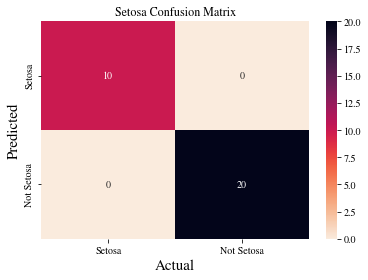

In [ ]:
conf_matrix = np.array([[len(true_positives),len(false_negatives)],[len(false_positives),len(true_negatives)]])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket_r', xticklabels=['Setosa','Not Setosa'], yticklabels= ['Setosa','Not Setosa'])
plt.xlabel('Actual', fontsize = 15)
plt.ylabel('Predicted', fontsize = 15)
plt.title('Setosa Confusion Matrix')
plt.show()

---

- Versicolor vs setosa, virginica

In [ ]:
#Modify the target vectors to be 1 for the versicolor class and -1 for the rest
target_versicolor_train = np.where(y_train == 1, 1,-1)
target_versicolor_test = np.where(y_test == 1, 1,-1)

# We train our perceptron model
w_versicolor = incremental_perceptron_training(X_train,target_versicolor_train,w_initial)
print(f'The final weight vector for the versicolor class is: {w_versicolor}')
print(f'And Thus the seperating hyperplane is: ({w_versicolor[0]}x1) + ({w_versicolor[1]}x2) + ({w_versicolor[2]}x3) + ({w_versicolor[3]}x4) - ({w_versicolor[4]}) = 0')

# We use the seperating hyperplane evaluation function to seperate the correctly and misclassified data, as well as the true and false positives and negatives
correctly_classified = seperating_line_evaluation(X_test,target_versicolor_test,w_versicolor)[0]
misclassified = seperating_line_evaluation(X_test,target_versicolor_test,w_versicolor)[1]
true_positives = seperating_line_evaluation(X_test,target_versicolor_test,w_versicolor)[2]
true_negatives = seperating_line_evaluation(X_test,target_versicolor_test,w_versicolor)[3]
false_positives = seperating_line_evaluation(X_test,target_versicolor_test,w_versicolor)[4]
false_negatives = seperating_line_evaluation(X_test,target_versicolor_test,w_versicolor)[5]

# We print the results
print('------EVALUATION-------')
print('Correctly classified:', correctly_classified)
print('Misclassified:',misclassified,'\n')

print('------True Positives & Negatives------')
print('Versicolor classified as Versicolor:',len(true_positives))
print('Setosa or Virginica classified as Setosa or Virginica:',len(true_negatives),'\n')

print('-----False Positives & Negatives-----')
print('Versicolor classified as Setosa or Virginica:',len(false_negatives))
print('Setosa or Virginica classified as Versicolor:',len(false_positives))

Run complete
The final weight vector for the versicolor class is: [  7.89  -19.33    2.857 -14.164  -5.   ]
And Thus the seperating hyperplane is: (7.890625x1) + (-19.328125x2) + (2.857421875x3) + (-14.1640625x4) - (-5.0) = 0
------EVALUATION-------
Correctly classified: [0, 1, 3, 4, 6, 7, 9, 10, 13, 16, 18, 20, 23, 25, 26, 27, 29]
Misclassified: [12, 24, 2, 5, 8, 11, 14, 15, 17, 19, 21, 22, 28] 

------True Positives & Negatives------
Versicolor classified as Versicolor: 0
Setosa or Virginica classified as Setosa or Virginica: 17 

-----False Positives & Negatives-----
Versicolor classified as Setosa or Virginica: 11
Setosa or Virginica classified as Versicolor: 2


The above results shown as a confusion matrix are as follows:

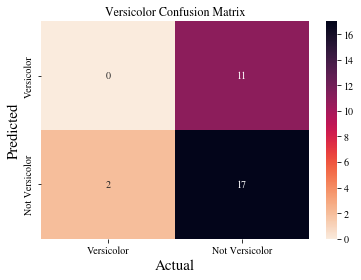

In [ ]:
conf_matrix = np.array([[len(true_positives),len(false_negatives)],[len(false_positives),len(true_negatives)]])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket_r', xticklabels=['Versicolor','Not Versicolor'], yticklabels= ['Versicolor','Not Versicolor'])
plt.xlabel('Actual', fontsize = 15)
plt.ylabel('Predicted', fontsize = 15)
plt.title('Versicolor Confusion Matrix')
plt.show()

---

- Virginica vs setosa, versicolor 

In [ ]:
#Modify the target vectors to be 1 for the virginica class and -1 for the rest
target_virginica_train = np.where(y_train == 2, 1,-1)
target_virginica_test = np.where(y_test == 2, 1,-1)

#We train our perceptron model
w_virginica = incremental_perceptron_training(X_train,target_virginica_train,w_initial)
print(f'The final  weight vector for the virginica class is: {w_virginica}')
print(f'And Thus the seperating curve is: ({w_virginica[0]}x1) + ({w_virginica[1]}x2) + ({w_virginica[2]}x3) + ({w_virginica[3]}x4) - ({w_virginica[4]}) = 0')
print('-----\n This separating line results in the following classification results: \n-----')

# We use the seperating hyperplane evaluation function to seperate the correctly and misclassified data, as well as the true and false positives and negatives
correctly_classified = seperating_line_evaluation(X_test,target_virginica_test,w_virginica)[0]
misclassified = seperating_line_evaluation(X_test,target_virginica_test,w_virginica)[1]
true_positives = seperating_line_evaluation(X_test,target_virginica_test,w_virginica)[2]
true_negatives = seperating_line_evaluation(X_test,target_virginica_test,w_virginica)[3]
false_positives = seperating_line_evaluation(X_test,target_virginica_test,w_virginica)[4]
false_negatives = seperating_line_evaluation(X_test,target_virginica_test,w_virginica)[5]

# We print the results
print('------EVALUATION-------')
print('Correctly classified:', correctly_classified)
print('Misclassified:',misclassified,'\n')

print('------True Positives & Negatives------')
print('Virginica classified as Virginica:',len(true_positives))
print('Setosa or Versicolor classified as Setosa or Versicolor:',len(true_negatives),'\n')

print('-----False Positives & Negatives-----')
print('Virginica classified as Setosa or Versicolor:',len(false_negatives))
print('Setosa or Versicolor classified as Virginica:',len(false_positives))

Run complete
The final  weight vector for the virginica class is: [-13.92 -12.08  20.1   18.48   7.  ]
And Thus the seperating curve is: (-13.921875x1) + (-12.078125x2) + (20.09375x3) + (18.484375x4) - (7.0) = 0
-----
 This separating line results in the following classification results: 
-----
------EVALUATION-------
Correctly classified: [1, 6, 10, 12, 13, 20, 24, 26, 27, 0, 2, 3, 4, 5, 7, 9, 11, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 28, 29]
Misclassified: [8] 

------True Positives & Negatives------
Virginica classified as Virginica: 9
Setosa or Versicolor classified as Setosa or Versicolor: 20 

-----False Positives & Negatives-----
Virginica classified as Setosa or Versicolor: 0
Setosa or Versicolor classified as Virginica: 1


The above results shown as a confusion matrix are as follows:

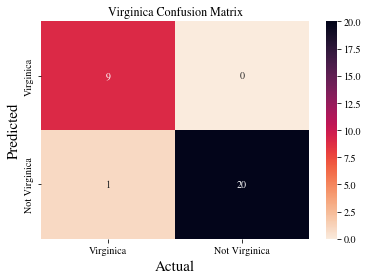

In [ ]:
conf_matrix = np.array([[len(true_positives),len(false_negatives)],[len(false_positives),len(true_negatives)]])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket_r', xticklabels=['Virginica','Not Virginica'], yticklabels= ['Virginica','Not Virginica'])
plt.xlabel('Actual', fontsize = 15)
plt.ylabel('Predicted', fontsize = 15)
plt.title('Virginica Confusion Matrix')
plt.show()

--- 


Running the perceptron algorithm on the IRIS PLANT DATABASE data and observing the results after multiple runs we get the following results:
- The Setosa class is linearly seperable from the Versicolor and Virginica classes. The seperating Hyperplane is  able to correctly classify Setosa as Setosa and Versicolor and Virginica as not Setosa. 

- The Versicolor class is not linearly seperable from Setosa and Virginica classes. The seperating Hyperplane missclassifies Versicolor as not Versicolor for half of the points, however it is able to correctly classify Setosa and Virginica as not Versicolor.

- The Virginica class is not linerarly seperable from Versicolor and Setosa classes. Although it only missclassifies 3 points as Virginica and it is able to correctly classify Setosa and Versicolor as not Virginica. Thus we are close to complete linear seperation.

- The Setosa class has complete linear seperation while the Virginica class has much better linear seperation compared to the Versicolor class.